# Are the Starting Materials for Synthesizing Your Target Molecules Commercially Available?

This utility reports whether the starting materials are commercially available for a set of synthesis targets given reactions. You give it your synthesis targets and the reaction to create each, it determines the starting materials, checks whether they are commercially available, and tells you whether each target is accessible--whether all its starting materials are commercially available.

Modern pharmaceutical and materials chemistry involves screening many candidate compounds. While much can now be done *in silico* (on a computer), promising compounds still need to be synthesized. [Divergent synthesis](https://en.wikipedia.org/wiki/Divergent_synthesis) can create a library of related compounds. One approach is to start with a diversity of commercially-available molecules, run the same reaction on them using the same co-reactant(s), and produce a diversity of target molecules that have a promising scaffold (core structure). A key question is, which starting materials are commercially available?

Here's an example graphical summary:

***Output molgrid***

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2023-02-07-Are-the-Starting-Materials-for-Synthesizing-Your-Target-Molecules-Commercially-Available.ipynb)*

In [187]:
import asyncio

import aiohttp
import rdkit
from codetiming import Timer
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions

In this scenario, imagine we have a promising scaffold in mind:

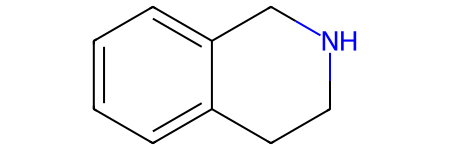

In [188]:
Chem.MolFromSmiles("C1Cc2ccccc2CN1")

and want to test the bioactivity of various linked rings:

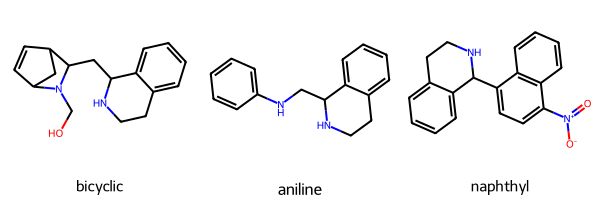

In [191]:
targets = ["OCN1C2CC(C=C2)C1CC1NCCc2ccccc12", "c1ccc(NCC2NCCc3ccccc32)cc1", "[O-][N+](=O)C1=CC=C(C2NCCc3ccccc23)C2=C1C=CC=C2"]
target_labels = ["bicyclic", "aniline", "naphthyl"]
mols = [Chem.MolFromSmiles(smiles) for smiles in targets]
Draw.MolsToGridImage(mols=mols, legends=target_labels)

So we want to determine if we can synthesize those three target molecules using commercially-available starting materials with two different reaction types, described below.

This utility uses
- [RDKit's ChemicalReaction class](http://rdkit.org/docs/cppapi/classRDKit_1_1ChemicalReaction.html) to reverse a reaction from target to starting materials.
- the free [PubChem APIs](https://pubchem.ncbi.nlm.nih.gov/docs/programmatic-access) to determine whether those starting materials are commercially available. PubChem gathers availability from multiple vendors, so we can call just one API source rather than calling dozens of suppliers.
- [Python's asyncio library](https://docs.python.org/3/library/asyncio.html) to speed getting API results back by making the API calls concurrently.

## Why Make API Calls Asynchronously

API calls an appreciable amount of time, perhaps 0.4-1 second, because they go over the Internet. So when making API calls, we want to minimize the number of calls to reduce both run time and the load on the server. This code thus gathers all the reactants from multiple reactions, then removes duplicates, so it doesn't make redundant API calls for a given molecule. Because each call can be done independently, it saves time to do them asynchronously. Asynchronous programming involves sending out a group of tasks to be completed independently, and accepting results whenever they come back. By contrast, synchronous programming has a known order of task execution, but is slower if you're waiting for each task to complete before you start the next one.

In this example, we make up to two API calls per molecule:
- First, to check if the molecule is in PubChem, and if so obtain its identifier (CID). This call uses PubChem like a catalog to find the molecule.
- Second, if the molecule exists in PubChem, to retrieve its commercial availability.

These two calls need to happen sequentially: We first need to get the molecule's identifier if it's in PubChem, then we use that identifier to make a second call to obtain the desired properties. So we can't make those two calls in parallel.

These figures demonstrate how we can save time by running API calls asynchronously: The asynchronous approach might take 0.8 seconds, while the synchronous approach might take 1.2 seconds. (For simplicity, we assume that each API call takes 0.4 s; in reality, the time for each call can vary based on the Internet connection, how busy the server is, etc.)

![Two tasks running synchronously, taking 1.2 seconds total](../images/timing_diagram_wide/002_sync_two_tasks.jpeg)

![Two tasks running asynchronously, taking 0.8 seconds total](../images/timing_diagram_wide/001_async_two_tasks.jpeg)

## Why Not To Make Too Many Concurrent API Calls
[PubChem asks you to limit API requests to 5 per second](https://pubchem.ncbi.nlm.nih.gov/docs/programmatic-access#section=Request-Volume-Limitations), so we shouldn't make API calls for too many reactants simultaneously. Each reactant needs at least one, and typically two, API calls.

[Asycnio's Semaphore](https://docs.python.org/3/library/asyncio-sync.html#asyncio.Semaphore) lets you limit the number of concurrent tasks. It may be helpful to think of multiple pipes, where each pipe can run only one task at a time. So you can vary the number of pipes from:
- 1: No concurrent tasks; equivalent to synchronous (all calls in serial)
- In between: Some simultaneous tasks
- Number of tasks: Fully simultaneous tasks--each task can run concurrently

It's thus advantageous to write your code asynchronously and use Semaphore. That way, you can easily adjust the degree of concurrency once your code is working and you need to adjust to limit the number of API calls per second.

![Four fully concurrent tasks, taking 0.8 seconds total](../images/timing_diagram_wide/003_four_fully_concurrent_tasks.jpeg)

Four tasks running in two pipes, taking 1.6 seconds total

![Alt text](../images/timing_diagram_wide/004_four_tasks_in_two_pipes.jpeg)

If you let each task run concurrently, the total time will be roughly the time of the longest task, for example 0.8 s.

If you allow some simultaneous tasks, for example two pipes for four tasks (reactants), several things are different:
- There is no guarantee of the order that the tasks will run in; it depends on the queueing that asyncio chooses. This is fine as long as you wait for all tasks to complete. (In a more sophisticated scheme for longer-running code, you could process and present results to the user as they come in.)
- Until all tasks are started, a new task enters (starts running in) a pipe when a pipe has completed its previous task.
- The total time is not deterministic, but should be roughly minimized given the constraint of fewer pipes than tasks.

By the way, the specific request type we use here [`aiohttp` also has a way to limit the number of concurrent connections](https://stackoverflow.com/questions/35196974/aiohttp-set-maximum-number-of-requests-per-second/43857526#43857526). For generality, we use Semaphore instead because it can be applied to any type of task.

## PubChem API Call Results
To demystify API calls, it's useful to think of them as corresponding to the information you could get interactively by clicking on links. (In fact, a modern development trend is for a web site to call its API to obtain the data, then format it to present to the user.) The difference between API calls and interactively viewing web pages is that APIs return information in a computer-friendly format, which makes it easier for your code to process the results.

We use two different PubChem APIs. First, we use [PUG (Power User Gateway) REST](https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest) to request the identifier of the molecule. The PUG REST request corresponds to interactively doing a SMILES search, for example https://pubchem.ncbi.nlm.nih.gov/#query=O=C(C)Oc1ccccc1C(=O)O&input_type=smiles where `O=C(C)Oc1ccccc1C(=O)O` is the SMILES string for the molecule of interest, here acetylsalicylic acid (aspirin). We request text format, so PUG REST returns a simple result: the identifier if it exists, or 0 (zero) if not, followed by a linebreak, for example `2244\n` where 2244 is the PubChem identifier for acetylsalicylic acid. Processing this result to obtain the identifier is simple.

Second, we use [PUG View](https://pubchem.ncbi.nlm.nih.gov/docs/pug-view) to request data about commercial availability. The PUG View request corresponds to interactively visiting the molecule's page, for example https://pubchem.ncbi.nlm.nih.gov/compound/2244, for acetylsalicylic acid. The data is more complicated here. It corresponds to the Chemical Vendors section on the web page. We chose to request XML format. Fortunately, we don't need to process all the data in the result, just check whether there is any vendor data.

If there is vendor data, the result includes:

```
<TOCHeading>Chemical Vendors</TOCHeading>
<Description>
A list of chemical vendors that sell this compound. ...
</Description>
```

If there is no vendor data, the result includes:

```
<Code>PUGVIEW.NotFound</Code>
<Message>No data found</Message>
```

So if `<Message>No data found</Message>` is present, we deem that the molecule is not commercially available.

## Code

In [156]:
import warnings
warnings.filterwarnings('ignore')

In [157]:
!pip install aiohttp
!pip install codetiming

In [159]:
class Reactant():
    """Store a reactant's commercial availability."""
        
    def __init__(self, smiles: str):
        """
        Construct a Reactant object to store the commercial availability of a reactant

        :param smiles: SMILES string representing a molecule
        """
        self.smiles = smiles
        self.mol = Chem.MolFromSmiles(smiles)

        @property
        def in_pubchem(self):
            return self._in_pubchem

        @in_pubchem.setter
        def in_pubchem(self, value: bool):
            """:param value: whether molecule is in PubChem"""
            self._in_pubchem = value

        @property
        def cid(self):
            return self._cid

        @cid.setter
        def cid(self, value: int):
            """:param value: PubChem CID (identifier) for molecule"""
            self._cid = value

        @property
        def commercially_available(self):
            return self._commercially_available

        @commercially_available.setter
        def commercially_available(self, value: bool):
            """:param value: whether molecule is commercially available, per PubChem"""
            self._commercially_available = value

        @property
        def pubchem_page(self):
            return self._pubchem_page

        @pubchem_page.setter
        def pubchem_page(self, value: str):
            """:param value: URL or PubChem page for molecule"""
            self._pubchem_page = value

    def __str__(self):
        """User-friendly printout in format:
        Reactant SMILES: NCCc1ccccc1, in_pubchem: True, cid: 1001, commercially_available: True, pubchem_page: https://pubchem.ncbi.nlm.nih.gov/compound/1001
        """
        str_print = f"Reactant SMILES: {self.smiles}"
        str_print += f", in_pubchem: {self.in_pubchem}"
        if hasattr(self, "cid"):
            str_print += f", cid: {self.cid}"
        if hasattr(self, "commercially_available"):
            str_print += f", commercially_available: {self.commercially_available}"
        if hasattr(self, "pubchem_page"):
            str_print += f", pubchem_page: {self.pubchem_page}"
        return str_print


In [160]:
class Reaction():
    """Store a reaction's target, reaction SMARTS, name (type), reactants, and commercial of reactants."""

    def __init__(self, target, reaction_smarts, name):
        """
        Construct a Reaction object 

        :param target: The molecule to synthesize as a SMILES string
        :param reaction_smarts: The reaction SMARTS as e.g. reactant1.reactant2>>product
        :param name: Name of the reaction, for user's information, e.g. Amine oxidation
        """
        self.target = target
        self.reaction_smarts = reaction_smarts
        self.name = name
        self.target_mol = Chem.MolFromSmiles(self.target)
        self.reactants = dict()

        @property
        def reactants(self):
            return self._reactants

        @reactants.setter
        def reactants(self, value: dict[str, object]):
            """:param value: Dictionary of SMILES:Reactant object pairs"""
            self._reactants = value

        @property
        def reactants_commercially_available(self):
            return self._reactants_commercially_available

    def tally_all_reactants_commercially_available(self):
        """
        Given the commercial availability of each reactant, determine whether they are all available
        Sets self._reactants_commercially_available to, and returns, that boolean value
        """
        for reactant in self.reactants:
            if not self.reactants[reactant].commercially_available:
                self._reactants_commercially_available = False
                return False
        self._reactants_commercially_available = True
        return True

    def __str__(self):
        """
        User-friendly printout in format:
        Reaction Pictet-Spengler target OCN1C2CC(C=C2)C1CC1NCCc2ccccc12, all reactants commercially available: False. Reactants: 1) NCCc1ccccc1 commercially available: True 2) O=CCC1C2C=CC(C2)N1CO commercially available: False
        """
        self.tally_all_reactants_commercially_available()
        str_print = f"Reaction {self.name} target {self.target}" 
        str_print += f", all reactants commercially available: {self._reactants_commercially_available}. Reactants:"
        reactant_number = 0
        for smiles, object in self.reactants.items():
            reactant_number += 1
            str_print += f" {reactant_number}) {smiles} commercially available: {object.commercially_available}"
        return str_print

In [161]:
def reverse_reaction(rxn_fwd):
    """
    Reverse an RDKit reaction
    Code adapted from https://www.rdkit.org/docs/Cookbook.html#reversing-reactions by Greg Landrum

    :param rxn_fwd: forward chemical reaction of class rdkit.Chem.rdChemReactions.ChemicalReaction
    :returns: reverse chemical reaction of class rdkit.Chem.rdChemReactions.ChemicalReaction
    """
    rxn_rev = Chem.ChemicalReaction()
    for i in range(rxn_fwd.GetNumReactantTemplates()):
        rxn_rev.AddProductTemplate(rxn_fwd.GetReactantTemplate(i))
    for i in range(rxn_fwd.GetNumProductTemplates()):
        rxn_rev.AddReactantTemplate(rxn_fwd.GetProductTemplate(i))
    rxn_rev.Initialize()
    return rxn_rev

In [162]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    """
    Flatten a 2D (nested) list into a 1D (non-nested) list

    :param twoD_list: The 2D list, e.g. [[a], [b, c]]
    :returns: 1D list, e.g. [a, b, c]
    """
    flat_list = []
    for row in twoD_list:
        for item in row:
            flat_list += [item]
    return flat_list

def longest_row(twoD_list: list[list]) -> int:
    """
    Find the longest row (sublist) a 2D (nested) list

    :param twoD_list: The 2D list, e.g. [[a], [b, c]]
    :returns: Length of the longest row, e.g. 2
    """
    return max(len(row) for row in twoD_list)

def pad_rows(twoD_list: list[list], row_length: int, filler = "") -> list[list]:
    """
    Pad each row (sublist) in a 2D (nested) list to a given length

    :param twoD_list: The 2D list, e.g. [[a], [b, c]]
    :param row_length: The length to pad to, e.g. 3
    :param filler: The sublist element to pad with, e.g. p
    :returns: Padded 2D list, e.g. [[a, p, p], [b, c, p]]
    """
    for row in twoD_list:
        padding = row_length - len(row)
        row += [filler] * padding
    return twoD_list

In [163]:
async def is_commercially_available(smiles):
    """
    Asynchronously check the availability of a queue of SMILES strings (chemicals) in PubChem
    Based on https://realpython.com/python-async-features/#asynchronous-non-blocking-http-calls

    :param smiles: A SMILES string (representing a molecule)
    :returns: Class Reactant object with information from PubChem
    """
    async with aiohttp.ClientSession() as session:
        # Create Reactant object, which will be populated during this function
        reactant = Reactant(smiles)

        timer = Timer(text=f"{{:.2f}}s for {smiles} PubChem API call(s)")

        timer.start()

        # Find the PubChem identifier (CID) for this SMILES string
        get_cid_URL = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/cids/TXT"
        try:
            async with session.get(get_cid_URL, ssl=False) as response:
                get_cid_response = await response.text()
        except:
            raise ConnectionError
        cid_str = get_cid_response.strip("\n")

        try:
            cid = int(cid_str)
        except ValueError:
            cid = 0

        if cid == 0:
            reactant.in_pubchem = False
            reactant.commercially_available = False
            timer.stop()
            return reactant
        else:
            reactant.cid = cid
            reactant.in_pubchem = True
            reactant.pubchem_page = f"https://pubchem.ncbi.nlm.nih.gov/compound/{cid}"

        # Get the compound's PubChem page
        compound_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/XML?heading=Chemical-Vendors"

        async with session.get(compound_url, ssl=False) as response:
            compound_vendors_response = await response.text()

        timer.stop()

        if "<Message>No data found</Message>" in compound_vendors_response:
            reactant.commercially_available = False
        else:
            reactant.commercially_available = True
    return reactant

In [164]:
# Set the number of simultaneous tasks to 2.
#   For synchronous (only one task at a time), instead set to 1.
#   For fully simultaneous, instead set to greater than or equal to the number of tasks.
sem = asyncio.Semaphore(2)

async def safe_calls(smiles):
    """Run a limited number of concurrent tasks
    Adapted from https://stackoverflow.com/questions/48483348/how-to-limit-concurrency-with-python-asyncio#48486557
    
    :param smiles: A SMILES string (representing a molecule)
    :returns: Class Reactant object with information from PubChem    
    """
    async with sem:  # semaphore limits num of simultaneous API calls
        return await is_commercially_available(smiles)

In [165]:
async def check_avail_smiles_set(smiles_set: set[str]) -> dict[str, Reactant]:
    """
    Feed asynchronous queue to check the availability of several SMILES strings (chemicals) in PubChem
    Adapted from https://stackoverflow.com/questions/48483348/how-to-limit-concurrency-with-python-asyncio#48486557

    :param smiles_set: Set of SMILES strings (representing molecules)
    :returns: Dictionary of SMILES:reactant pairs, where reactant is class Reactant object
    """
    # Determine commercial availability of each reactant
    with Timer(text="-----\n{:.2f}s total elapsed time for PubChem API calls"):
        tasks = [asyncio.ensure_future(safe_calls(smiles)) for smiles in smiles_set]
        reactants = await asyncio.gather(*tasks)  # await completion of all API calls
        # Note: "A more modern way to create and run tasks concurrently and wait for their completion is 
        #   asyncio.TaskGroup" https://docs.python.org/3/library/asyncio-task.html#asyncio.TaskGroup
        #   but this was only implemented in Python 3.11, so we use a method that is
        #   compatible with older versions of Python.

    # Put reactants in dictionary of SMILES:Reaction object
    smiles_avail = dict()
    for reactant in reactants:
        smiles_avail[reactant.smiles] = reactant
    
    return smiles_avail

In [166]:
async def check_avail_smiles_list(smiles_list):
    """Check whether each SMILES in a list is commercially available
    
    :param smiles_list: List of SMILES strings (representing molecules)
    :returns: Dictionary of SMILES:reactant pairs, where reactant is class Reactant object
    """
    smiles_set = set(smiles_list)

    # When running in Jupyter, use this next line:
    smiles_avail = await check_avail_smiles_set(smiles_set)
    # When running outside Jupyter, use this next line instead:
    # smiles_avail = asyncio.run(check_avail_smiles_set(smiles_set))

    return smiles_avail

In [171]:
async def check_reactions(target_reaction_list: list[list[str, str, str]]):
    """
    Check whether the starting materials in a list of reactions are commercially available
    :param target_reaction_list: List of reactions in format [target (SMILES), reaction SMARTS, reaction name]
    :returns: MolGrid drawing with one reaction in each row,
    nested list of where each sublist gives for a reaction: [Reaction object, all reactants commercially available]
    """

    all_reactants_list = []

    # List of Reaction objects
    reactions = []
    for target_reaction in target_reaction_list:
        reaction = Reaction(target_reaction[0], target_reaction[1], target_reaction[2])

        # Create forward reaction
        rxn_fwd = Chem.ReactionFromSmarts(reaction.reaction_smarts)

        # Reverse reaction
        rxn_rev = reverse_reaction(rxn_fwd)

        # Run reverse reaction to determine starting materials
        reactants = rxn_rev.RunReactants([reaction.target_mol])[0]
        for reactant_mol in reactants:
            reactant_smiles = Chem.MolToSmiles(reactant_mol)
            reaction.reactants[reactant_smiles] = None

        # Add starting materials to set of starting materials
        for reactant in reaction.reactants:
            all_reactants_list.append(reactant)
        
        # Add reaction to list of reactions
        reactions.append(reaction)

    # Check commercial availability of set of starting materials
    smiles_avail = await check_avail_smiles_list(all_reactants_list)

    # reaction_reactants_avail format is:
    #   [[reaction object 0, all reactants available], [reaction object 1, all reactants available], ...]
    reaction_reactants_avail = []
    for reaction in reactions:
        # Add information to Reaction objects
        for reactant in reaction.reactants:
            # Set value for key of reactant SMILES, to reactant object from smiles_avail
            reaction.reactants[reactant] = smiles_avail[reactant]

        reaction.tally_all_reactants_commercially_available()

        # Return results
        reaction_reactants_avail.append([reaction, reaction._reactants_commercially_available])

    # Create and format molgrid output
    mols_2D = []
    legends_2D = []
    for reaction in reactions:
        mols_row = []
        legends_row = []
        mols_row.append(Chem.MolFromSmiles(reaction.target))
        legends_row.append(f"{reaction.name} target accessible: {reaction._reactants_commercially_available}")
        for reactant in reaction.reactants:
            mols_row.append(Chem.MolFromSmiles(reactant))
            legends_row.append(f"Reactant available: {reaction.reactants[reactant].commercially_available}")
        mols_2D.append(mols_row)
        legends_2D.append(legends_row)
    
    # Create null molecule (has no atoms) as filler for empty molecule cells
    null_mol = Chem.MolFromSmiles("")
    pad_rows(mols_2D, longest_row(mols_2D), filler=null_mol)
    pad_rows(legends_2D, longest_row(mols_2D))

    mols = flatten_twoD_list(mols_2D)
    legends = flatten_twoD_list(legends_2D)

    dwg = Draw.MolsToGridImage(mols=mols, legends=legends, molsPerRow=len(mols_2D[0]))
    return dwg, reaction_reactants_avail

## Setting up Your Reactions

You specify each reaction as a list of:
- target molecule: The SMILES string of the molecule you want to synthesize, for example "OCN1C2CC(C=C2)C1CC1NCCc2ccccc12"
- [reaction SMARTS](https://www.rdkit.org/docs/source/rdkit.Chem.rdChemReactions.html#rdkit.Chem.rdChemReactions.ChemicalReaction): SMARTS strings for the reactant(s) and products in the form for example `reactant1.reactant2>>product`, e.g. "[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1.[#6:11]-[CH1;R0:10]=[OD1]>>[c:1]12:[c:2](-[CH2:7]-[CH2:8]-[NH1:9]-[C:10]-2(-[#6:11])):[c:3]:[c:4]:[c:5]:[c:6]:1"
- name, which is simply for labeling for human readability, for example "Pictet-Spengler"

You then provide a list of one or more reactions, where each reaction is a sublist.

0.65s for Nc1ccc(C2NCCc3ccccc32)c2ccccc12 PubChem API call(s)
0.76s for NCCc1ccccc1 PubChem API call(s)
0.48s for O=CCC1C2C=CC(C2)N1CO PubChem API call(s)
0.58s for O=CCNc1ccccc1 PubChem API call(s)
-----
1.23s total elapsed time for PubChem API calls

Are starting materials commercially available for reaction -> target:


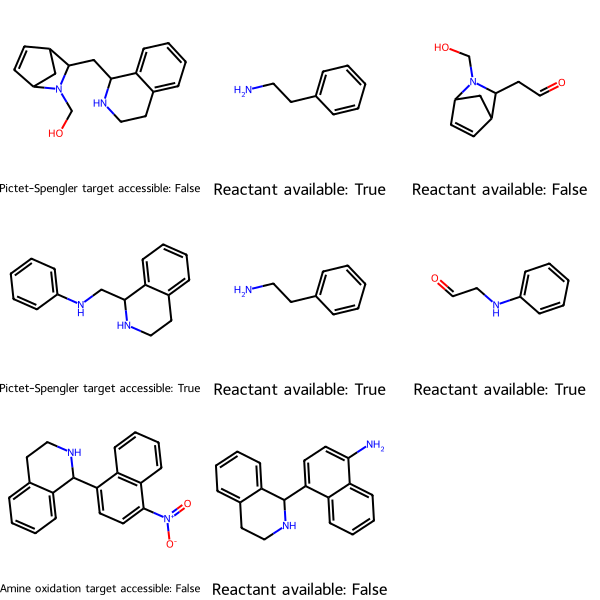

In [172]:
# Set up targets and reactions
bicyclic_target = "OCN1C2CC(C=C2)C1CC1NCCc2ccccc12"
aniline_target = "c1ccc(NCC2NCCc3ccccc32)cc1"
naphthyl_target = "[O-][N+](=O)C1=CC=C(C2NCCc3ccccc23)C2=C1C=CC=C2"

# Pictet-Spengler reaction SMARTS from https://www.rdkit.org/docs/Cookbook.html#reversing-reactions by Greg Landrum
pictet_spengler_rxn = '[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1.[#6:11]-[CH1;R0:10]=[OD1]>>[c:1]12:[c:2](-[CH2:7]-[CH2:8]-[NH1:9]-[C:10]-2(-[#6:11])):[c:3]:[c:4]:[c:5]:[c:6]:1'
pictet_spengler = [pictet_spengler_rxn, "Pictet-Spengler"]

amine_oxidation_rxn = "[*:1][Nh2:2]>>[*:1][Nh0:2](~[OD1])~[OD1]"

# Reaction format: [target (SMILES), reaction SMARTS, reaction name]
rxn1 = [bicyclic_target] + pictet_spengler
rxn2 = [aniline_target] + pictet_spengler
rxn3 = [naphthyl_target, amine_oxidation_rxn, "Amine oxidation"]

# Create list of reactions
rxns = [rxn1, rxn2, rxn3]

# Check list of reactions: Are starting materials commercially available?

# When running in Jupyter, use this next line:
dwg, reaction_reactants_avail = await check_reactions(rxns)
# When running outside Jupyter, use this next line instead:
#dwg, reaction_reactants_avail = asyncio.run(check_reactions(rxns))

dwg


`check_reactions` returns two results, a drawing and a list of reactions and whether each is accessible, that is, whether all its reactants are commercially available. To view the results graphically, call the drawing. The first column is the target and tells whether it's accessible. Each subsequent column is a reactant and tells whether it's commercially available.

`reaction_reactants_avail` is a nested list where each sub-list represents the reaction, then whether its target is accessible.

In [169]:
reaction_reactants_avail

[[<__main__.Reaction at 0x7fe4e1642fe0>, False],
 [<__main__.Reaction at 0x7fe4e14b70a0>, True],
 [<__main__.Reaction at 0x7fe4e14b4970>, False]]

## Checking the Commercial Availability of any List of Molecules
If you don't want to use the reaction functionality, and simply want to check whether a list of molecules is commercially available, you can call `check_avail_smiles_list` directly with a list of SMILES strings.

0.53s for O=CCC1C2C=CC(C2)N1CO PubChem API call(s)
0.73s for c1ccccc1 PubChem API call(s)
1.13s for O=C(C)Oc1ccccc1C(=O)O PubChem API call(s)
-----
1.67s total elapsed time for PubChem API calls


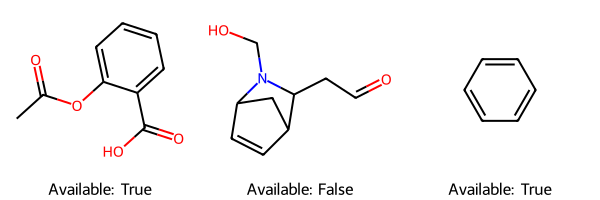

In [186]:
# Check a list of reactants
smiles_list = ["O=C(C)Oc1ccccc1C(=O)O","O=CCC1C2C=CC(C2)N1CO", "c1ccccc1"]

# When running in Jupyter, use this next line:
smiles_avail_async = await check_avail_smiles_list(smiles_list)
# When running outside Jupyter, use this next line instead:
#smiles_avail = asyncio.run(check_avail_smiles_list(smiles_list))

# Put reactant objects in same order they were supplied:
#   Because check_avail_smiles_list runs asynchronously, 
#   no guarantee that it will return molecules in same order supplied
smiles_avail = [smiles_avail_async[smiles] for smiles in smiles_list]

# Create and format molgrid output
mols = [Chem.MolFromSmiles(reactant.smiles) for reactant in smiles_avail]
legends = [f"Available: {reactant.commercially_available}" for reactant in smiles_avail]

dwg = Draw.MolsToGridImage(mols=mols, legends=legends)
dwg


## Improvements for Use in Production
If you wanted to use this scheme in production code, a few changes would be wise.

This code uses a SMILES string as a dictionary key. It would be better to use a key that's guaranteed to be shorter, for example a serial identification number, e.g. 1, 2, 3. The only time this code creates SMILES strings is when it converts from an RDKit molecule (as given by the reverse reaction for starting materials) to a SMILES string once for each reactant, helping ensure that two different SMILES strings are not created for identical molecules. ([RDKit's MolToSmiles function](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolToSmiles) returns the canonical SMILES string for a molecule, so it should give consistent results if called repeatedly on the same molecule.)

Similarly, you might want to use an identifier for each Reaction object, so you could use it as a key in a dictionary.

This code assumes only one product for a reaction. In the vast majority of cases, you're interested in only one product for a reaction, but for a reaction which produces a byproduct, such as water for a condensation reaction, there could be multiple products.

If there are many reactions or reactants, you might want to process and present results to the user as they come in. That way, the user can tell there's progress, and start getting some results before they all come in.

Finally, the presence in PubChem of vendors for a chemical may not be definitive about whether it's commercially available. First, as [Kurt Thorn pointed out](https://fosstodon.org/@kurtthorn/109765203870437567), "The definition of commercially available is somewhat fuzzy as many of these vendors aggregate compounds from multiple suppliers, some of which are synthesized on demand." Conversely, a vendor might not have any material in stock despite claiming availability. Or the vendor might have some in stock, but not as much as you need, or be unable to obtain it in the time frame you need. Or the unit price might be prohibitively expensive. So PubChem's data should be considered a screening tool, and before proceeding with a divergent synthesis plan, you should go to particular vendors, get quotations, and check if they can provide the material in the quantity, time frame, and price you need.

## Acknowledgements

Thanks to the [Kawalt Lab at Indiana Biosciences Research Institute](https://www.indianabiosciences.org/kalwat-lab) for [suggesting on Mastodon](https://fosstodon.org/@Kalwat_Lab@mas.to/109765367942971549) to use PubChem's APIs to determine the commercial availability of molecules. Thanks to [Kurt Thorn](https://fosstodon.org/@kurtthorn) for [suggesting other APIs](https://fosstodon.org/@kurtthorn/109765076448231287).